## This file makes machine learning application for individual packets for Aalto University. 
### Used machine learning algorithms: RF (Random Forest), NB (Naïve Bayes), kNN (k-Nearest Neighbours), GB (Gradient Boosting), DT (Decision Trees), and SVM (Support Vector Machine)

--------------

###  importing relevant libraries

In [28]:
#%matplotlib inline
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import csv
import math
#import seaborn as sns
#import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report

### Discovering dataset

In [17]:
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add
files_add=find_the_way('./','.csv')
files_add.pop(1)
files_add.pop(1)
files_add

['./IoTSentinel_FP_MAIN.csv',
 './IoTSense_FP_MAIN.csv',
 './IoTDevID_FP_MAIN.csv']

### Discovering Labels

In [18]:
def target_names():
    name=files_add[0]
    df = pd.read_csv(name)
    target_names=sorted(list(df[df.columns[-2]].unique()))
    return target_names
target_names=target_names()
target_names

['Amazon Echo',
 'Android Phone',
 'Belkin Wemo switch',
 'Belkin wemo motion sensor',
 'Blipcare Blood Pressure meter',
 'Dropcam',
 'HP Printer',
 'IPhone',
 'Insteon Camera',
 'Light Bulbs LiFX Smart Bulb',
 'MacBook',
 'MacBook/Iphone',
 'NEST Protect smoke alarm',
 'Netatmo Welcome',
 'Netatmo weather station',
 'PIX-STAR Photo-frame',
 'Samsung Galaxy Tab',
 'Samsung SmartCam',
 'Smart Things',
 'TP-Link Day Night Cloud camera',
 'TP-Link Smart plug',
 'TPLink Router Bridge LAN (Gateway)',
 'Triby Speaker',
 'Withings Aura smart sleep sensor',
 'Withings Smart Baby Monitor',
 'Withings Smart scale',
 'iHome']

### Hyperparameters of machine learning algorithms (except SVM, Due to the time required, SVM was run in a separate session at the end of the file)

# NB

In [19]:
ml_list={"Naive Bayes":MultinomialNB(alpha=1.0),
"DT_r" :DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=22,
                       max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best'),  
"Random Forest R":RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=27, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False),
"KNN_R":KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='distance'),
"GB":GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           min_samples_leaf=0.24545454545454548,
                           min_samples_split=0.28181818181818186,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None,
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)}

### This part is the main part of the file. Cross-validates the respective datasets 10-time 10-fold and prints the results (general results, class-based results and confusion matrix).

In [33]:
ths = open("08_2020_NB.csv", "w")
ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time))\n")
repetition=1
main_dataset=pd.read_csv("FP_MAIN.csv")
from collections import OrderedDict
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s'%
           ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total"))
packet_labels = {}
names = {}
for ii in ml_list:
    if packet_labels != {}:
        printing = 0
        for k,v in packet_labels.items():
            if printing == 5:
                break
            if len(v) == 3:
                for val in v:
                    print(names[val])
                print(main_dataset.iloc[k])
                printing += 1
    for loop in files_add:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        for i in range(repetition):
            #rnd = random()
            #kfold = KFold(2, shuffle=True, random_state=0)  
            cv=0
            df = pd.read_csv(loop)#,header=None )
            if "Mac" in df.columns:
                del df["Mac"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-2]]
            X=np.array(X)
            df[df.columns[-2]] = df[df.columns[-2]].astype('category')
            y=df[df.columns[-2]].cat.codes
            names = dict(enumerate(df[df.columns[-2]].cat.categories)) 
            #scaler = Normalizer().fit(X)
            #X = scaler.transform(X)
            # summarize transformed data
            dname=loop[2:-9]
            #for train_index, test_index in kfold.split(X):
            results_y=[]
            X_train, X_test = X[:int(len(X)*0.7)], X[int(len(X)*0.7):]
            print(X_train.shape)
            y_train, y_test = y[:int(len(X)*0.7)], y[int(len(X)*0.7):]  
            rus = NearMiss()
            X_train, y_train = rus.fit_resample(X_train, y_train)
            print(X_train.shape)
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]
                #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
            pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
            f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
            #report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
            #cr = pd.DataFrame(report).transpose()
            #if class_based_results.empty:
            #    class_based_results =cr
            #else:
            #    class_based_results = class_based_results.add(cr, fill_value=0)
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy_b.append(balanced_accuracy_score( y_test,predict))
            accuracy.append(accuracy_score(y_test, predict))
            #clf.score(X_test, y_test))
            #print(balanced_accuracy_score( y_test,predict))
            #t_time.append(float((time.time()-second)) )
            kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
            labels=None, weights=None, sample_weight=None)),15))
            print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
                str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),2)), 
                str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2))))
            #lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(round(np.mean(test_time)+np.mean(train_time),15))+"\n")

            # ths.write (lines)

            #df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            #results_y.append(predict)
            #if cm.empty:
            #    cm =df_cm
            #else:
            #    cm = cm.add(df_cm, fill_value=0)
 
        #print(class_based_results/100) 
        #cm=cm/100
        #graph_name="confusion matrix" +str(ii)       
        #plt.figure(figsize = (20,14))
        #sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True)
        #plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
        #plt.show()
        #print(cm)
        index = 0
        for label in predict:
            key = index
            index += 1
            if key not in packet_labels:
                packet_labels[key] = [label]
            elif label not in packet_labels[key]:
                packet_labels[key].append(label)
ths.close()  

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   
(1641493, 23)
(2064, 23)
IoTSentinel_FP  0   1   Naive   0.0   0.01  0.0   0.01  0.0   0.0   0.0      0.18    0.19    
(1641493, 20)
(2064, 20)
IoTSense_FP     0   1   Naive   0.5   0.04  0.04  0.03  0.03  0.24  0.0      0.15    0.15    
(1641493, 25)
(2064, 25)
IoTDevID_FP     0   1   Naive   0.0   0.01  0.0   0.01  0.0   -0.0  0.01     0.16    0.17    
Withings Smart scale
TPLink Router Bridge LAN (Gateway)
IPhone
ARP                             0
LLC                             0
EAPOL                           0
IP                              1
ICMP                            0
ICMP6                           0
TCP                             1
UDP                             0
TCP_w_size                   2549
HTTP                            0
HTTPS                           1
DHCP                            0
BOOTP                           0
SSDP                            0
DNS       

KeyboardInterrupt: 

### Hyperparameters of SVM

In [9]:
ml_list={"SVM":SVC(C=9.033197579781678, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=1.0312187582625605, kernel='rbf', max_iter=-1, probability=True,
    random_state=1, shrinking=True, tol=0.001, verbose=False)}

In [10]:
files_add

['./IoTSentinel.csv', './IoTSense.csv', './IoTDevID.csv']

### (For SVM) This part is the main part of the file. Cross-validates the respective datasets 10-time 10-fold and prints the results (general results, class-based results and confusion matrix). 

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   
IoTSentinel          0   1   SVM     0.71  0.57  0.66  0.57  0.61  0.66  2723.57  32.12   2755.69 
IoTSentinel          0   2   SVM     0.71  0.59  0.68  0.59  0.62  0.66  2698.53  32.07   2730.61 
IoTSentinel          0   3   SVM     0.71  0.59  0.67  0.59  0.62  0.67  2687.39  32.0    2719.39 
IoTSentinel          0   4   SVM     0.7   0.57  0.64  0.57  0.6   0.65  2731.67  31.9    2763.57 
IoTSentinel          0   5   SVM     0.72  0.57  0.67  0.57  0.61  0.67  3020.76  32.21   3052.97 
IoTSentinel          0   6   SVM     0.71  0.59  0.67  0.59  0.62  0.66  2711.03  32.09   2743.11 
IoTSentinel          0   7   SVM     0.71  0.59  0.68  0.59  0.62  0.67  2731.95  32.04   2763.99 
IoTSentinel          0   8   SVM     0.71  0.59  0.68  0.59  0.62  0.67  2713.6   32.08   2745.67 
IoTSentinel          0   9   SVM     0.71  0.59  0.67  0.59  0.61  0.67  2729.45  32.01   2761.46 
IoTSentinel    

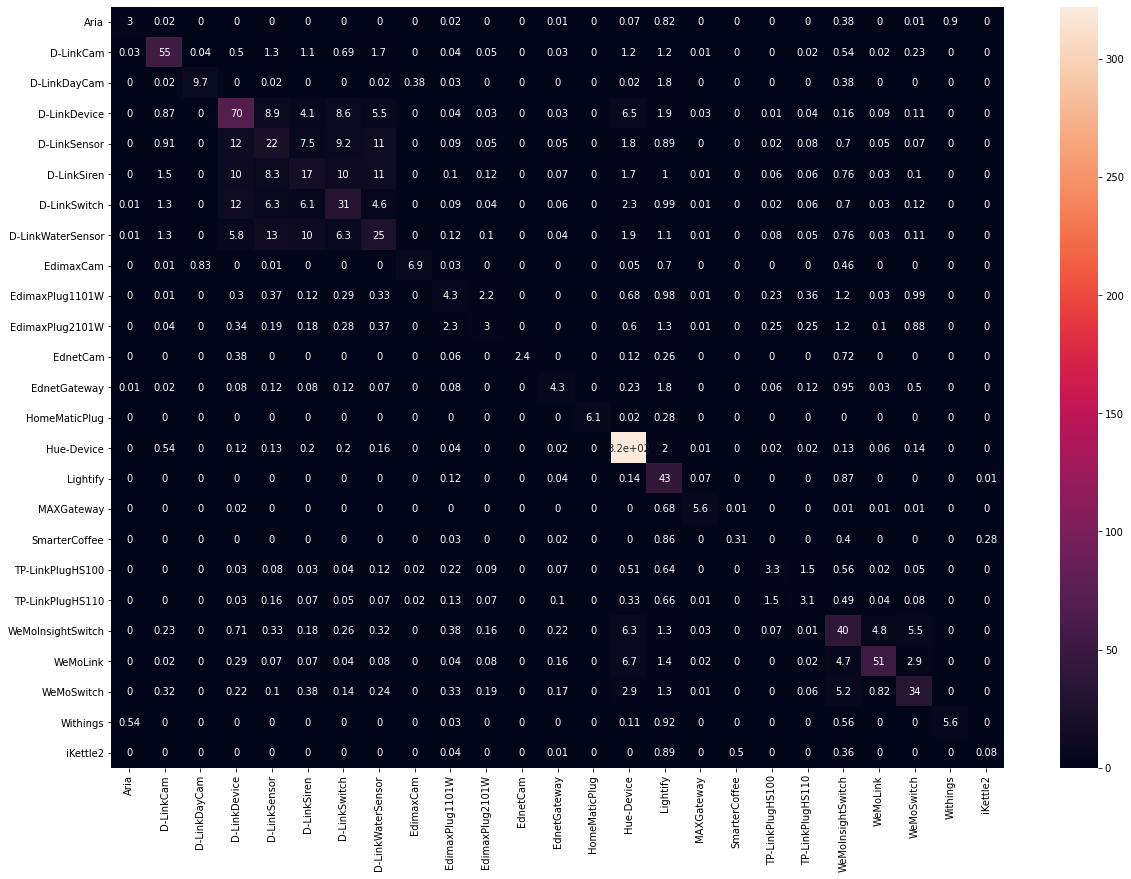





IoTSense            0   1   SVM     0.69  0.52  0.62  0.52  0.55  0.64  741.78   29.08   770.86  
IoTSense            0   2   SVM     0.69  0.52  0.61  0.52  0.54  0.64  694.2    28.92   723.11  
IoTSense            0   3   SVM     0.68  0.51  0.61  0.51  0.54  0.63  691.84   28.87   720.71  
IoTSense            0   4   SVM     0.68  0.5   0.63  0.5   0.53  0.63  696.5    28.79   725.29  
IoTSense            0   5   SVM     0.68  0.52  0.62  0.52  0.55  0.63  686.95   28.78   715.74  
IoTSense            0   6   SVM     0.67  0.51  0.61  0.51  0.54  0.62  690.68   28.7    719.38  
IoTSense            0   7   SVM     0.68  0.53  0.62  0.53  0.55  0.63  688.42   29.18   717.6   
IoTSense            0   8   SVM     0.68  0.5   0.61  0.5   0.52  0.63  691.39   28.73   720.12  
IoTSense            0   9   SVM     0.67  0.49  0.59  0.49  0.52  0.62  688.59   28.74   717.33  
IoTSense            0   10  SVM     0.68  0.52  0.62  0.52  0.54  0.63  695.21   28.85   724.05  
                

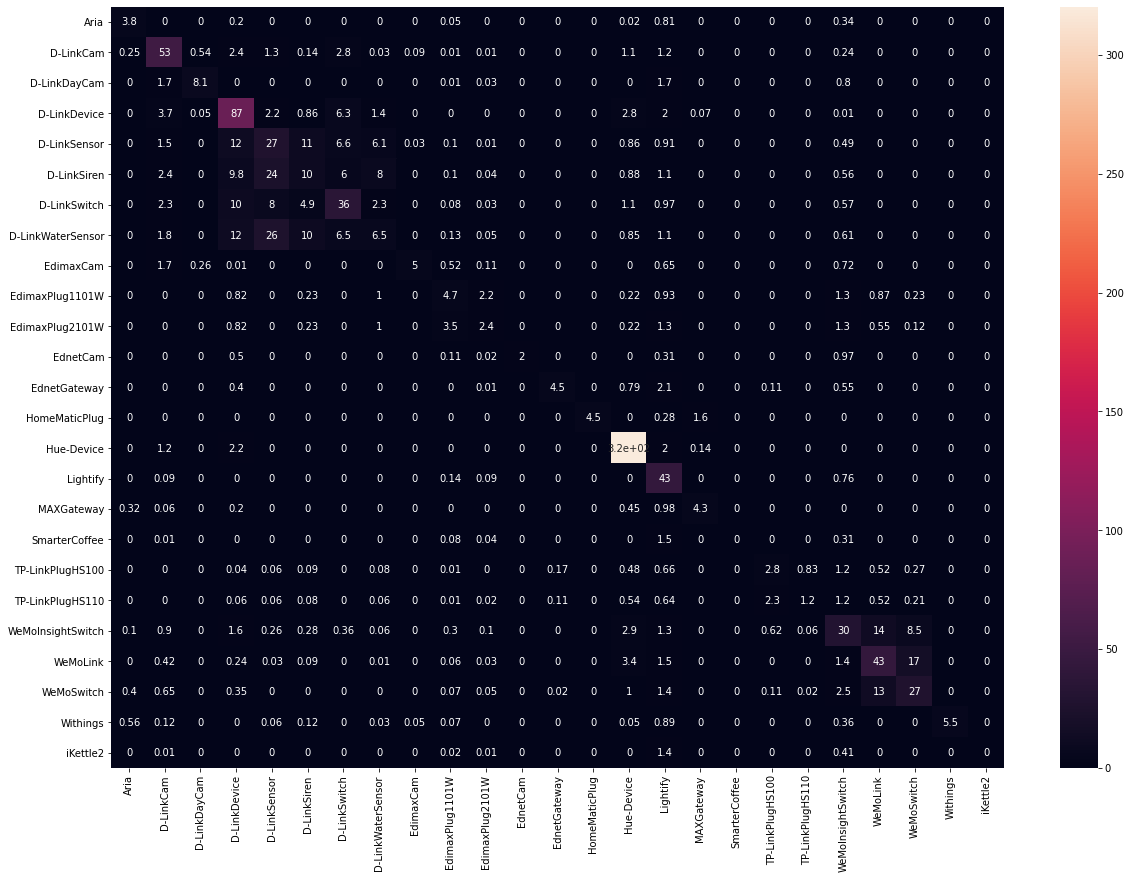





IoTDevID            0   1   SVM     0.75  0.61  0.7   0.61  0.65  0.71  3821.74  29.6    3851.34 
IoTDevID            0   2   SVM     0.75  0.61  0.7   0.61  0.64  0.71  3764.98  29.49   3794.47 
IoTDevID            0   3   SVM     0.75  0.61  0.7   0.61  0.64  0.7   3776.99  29.5    3806.49 
IoTDevID            0   4   SVM     0.74  0.62  0.71  0.62  0.65  0.7   3764.03  29.48   3793.51 
IoTDevID            0   5   SVM     0.75  0.62  0.68  0.62  0.64  0.71  3801.07  29.61   3830.68 
IoTDevID            0   6   SVM     0.75  0.62  0.7   0.62  0.65  0.71  3820.75  29.55   3850.3  
IoTDevID            0   7   SVM     0.75  0.62  0.7   0.62  0.65  0.71  3822.79  29.54   3852.33 
IoTDevID            0   8   SVM     0.75  0.62  0.7   0.62  0.65  0.71  3788.31  29.56   3817.87 
IoTDevID            0   9   SVM     0.75  0.61  0.7   0.61  0.65  0.71  3780.03  29.55   3809.58 
IoTDevID            0   10  SVM     0.75  0.62  0.71  0.62  0.66  0.71  3796.01  29.58   3825.59 
                

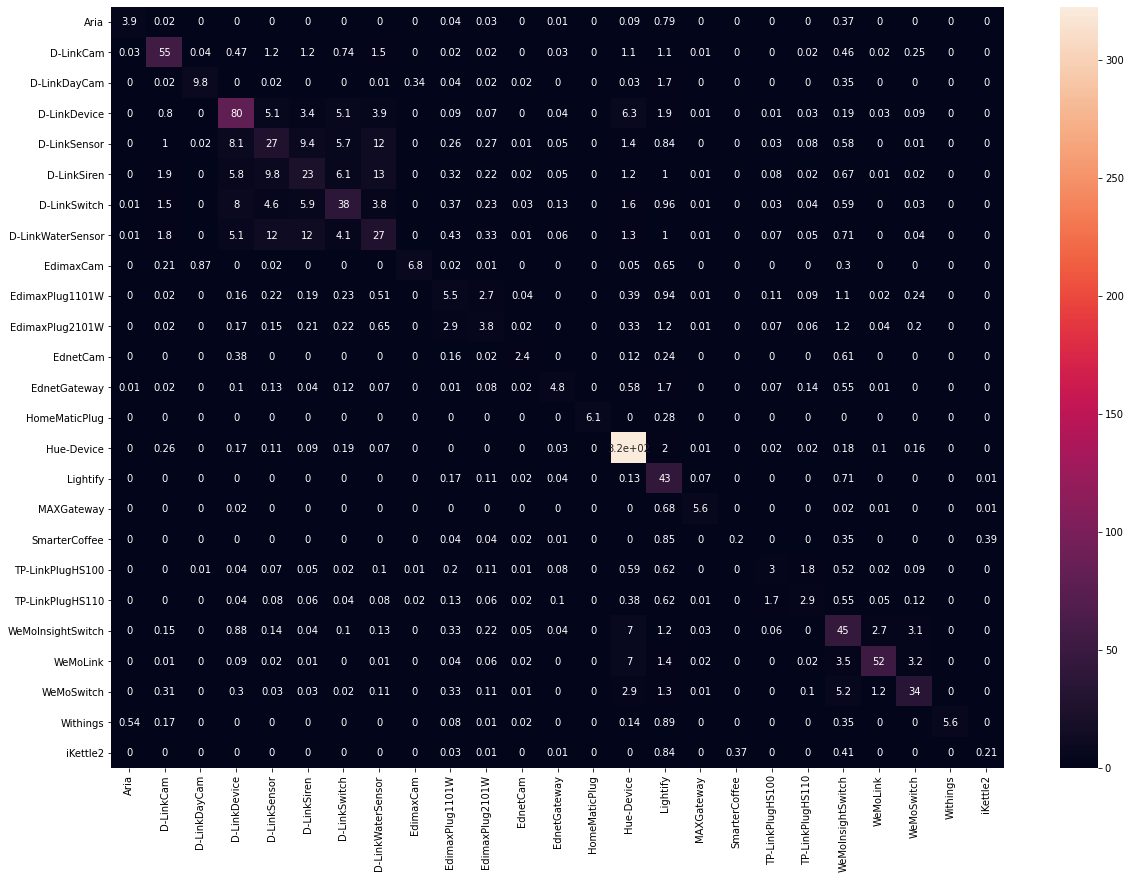

In [11]:
ths = open("1_ten_svm.csv", "w")
ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time))\n")
repetition=1

from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import Normalizer
print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s'%
           ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total"))
for loop in files_add:
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        for i in range(repetition):
            rnd = random()
            kfold = KFold(10, True, int(rnd*100))  
            cv=0
            df = pd.read_csv(loop)#,header=None )
            # del df["Mac"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            #scaler = Normalizer().fit(X)
            #X = scaler.transform(X)
            # summarize transformed data
            dname=loop[7:-4]
            X.shape
            for train_index, test_index in kfold.split(X):
                results_y=[]
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]
                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
                pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
                f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
                report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
                cr = pd.DataFrame(report).transpose()
                if class_based_results.empty:
                    class_based_results =cr
                else:
                    class_based_results = class_based_results.add(cr, fill_value=0)
                precision.append(float(pr))
                recall.append(float(rc))
                f1.append(float(f_1))
                accuracy_b.append(balanced_accuracy_score( y_test,predict))
                accuracy.append(accuracy_score(y_test, predict))
                #clf.score(X_test, y_test))
                #print(balanced_accuracy_score( y_test,predict))
                #t_time.append(float((time.time()-second)) )
                kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
                labels=None, weights=None, sample_weight=None)),15))
                print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
                    str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),2)), 
                    str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2))))
                lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(round(np.mean(test_time)+np.mean(train_time),15))+"\n")

                ths.write (lines)

                df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
                results_y.append(predict)
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)
 
        print(class_based_results/100) 
        cm=cm/100
        graph_name="confusion matrix" +str(ii)       
        #plt.figure(figsize = (20,14))
        #sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True)
        #plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
        #plt.show()
        #print(cm)
        print("\n\n\n") 
ths.close()  